In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

torch.manual_seed(42)

In [2]:
import PIL

def monoImageLoader(path):
    with open(path, 'rb') as f:
        img = PIL.Image.open(f)
        return img.convert("L")
    
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

train_dataset = torchvision.datasets.ImageFolder(
    root = '/data/datasets/fonts/rendered/alphabet_upper_split_05/train',
    loader = monoImageLoader,
    transform = transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=200, shuffle=True,num_workers=10
)

test_dataset = torchvision.datasets.ImageFolder(
    root = '/data/datasets/fonts/rendered/alphabet_upper_split_05/test',
    loader = monoImageLoader,
    transform = transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=5000, shuffle=False,num_workers=10
)

assert(train_dataset.classes == test_dataset.classes)
print("Classes:", train_dataset.classes)

train_iter = iter(train_loader)
test_iter = iter(test_loader)
train_images, train_labels = train_iter.next()
print("Batch shape:", train_images.size())
print("Labels:", train_labels)

Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Batch shape: torch.Size([200, 1, 50, 50])
Labels: tensor([ 4, 25,  3, 23,  0, 10, 24, 24,  0, 12, 17,  3,  8, 19, 15,  4, 23,  4,
        14,  2, 13,  8, 24,  6,  3, 12, 19, 24, 10,  0,  3, 14,  0,  2, 13,  4,
        15, 17, 24, 20,  4, 20,  4, 10,  6, 17,  0, 16,  2,  0, 13, 10,  1,  9,
         4, 15,  1, 21,  6,  1,  8, 15, 12,  0,  5,  7, 16, 16, 12, 12,  6, 24,
         7, 11, 24, 12,  4,  6,  2, 20,  2, 13,  9,  2,  2,  9,  2,  7,  4,  8,
        14,  4,  1,  4, 25,  3, 19,  7, 22, 23,  5,  0,  5, 22,  1, 15, 24,  8,
        14,  4,  9, 20, 16,  8, 21, 22,  4, 24, 18, 17, 23, 16,  6,  5, 16, 17,
        11,  6,  3,  6, 17, 25, 25, 13,  4,  6, 13,  6,  8,  4,  1, 25,  7, 18,
         5,  7, 17, 18, 17, 15, 13, 23,  7, 23,  5, 23, 25, 24,  1,  2,  1, 17,
        25,  6,  2, 15, 10,  2, 12, 24, 14, 14,  4, 12,  9, 12,  1,  2, 22, 18,
         5

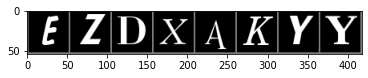

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(train_images[:8]))

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 16, 3)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(train_dataset.classes))
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
net = Net()
n = net(train_images)
print("Batch output shape:", n.shape)

for i, p in enumerate(net.parameters()):
    print("Parameters", i, p.size())
print("Trainable parameters:", sum([p.numel() for p in net.parameters()]))

Batch output shape: torch.Size([200, 26])
Parameters 0 torch.Size([6, 1, 3, 3])
Parameters 1 torch.Size([6])
Parameters 2 torch.Size([16, 6, 3, 3])
Parameters 3 torch.Size([16])
Parameters 4 torch.Size([16, 16, 3, 3])
Parameters 5 torch.Size([16])
Parameters 6 torch.Size([120, 256])
Parameters 7 torch.Size([120])
Parameters 8 torch.Size([84, 120])
Parameters 9 torch.Size([84])
Parameters 10 torch.Size([26, 84])
Parameters 11 torch.Size([26])
Trainable parameters: 46474


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  net = nn.DataParallel(net)

net.to(device)

Let's use 2 GPUs!


DataParallel(
  (module): Net(
    (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (fc1): Linear(in_features=256, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=26, bias=True)
  )
)

In [7]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(comment="_alphabet")

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.002, momentum=0.9)


global_step = 0
for epoch in range(1):
    
    for train_minibatch, (train_inputs, train_labels) in enumerate(train_loader):
        global_step += 1
        
        # Core training loop
        train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)

        optimizer.zero_grad()
        train_outputs = net(train_inputs)
        train_loss = criterion(train_outputs, train_labels)
        train_loss.backward()
        optimizer.step()
        
        writer.add_scalar("Loss/train", train_loss.item(), global_step)
        
        with torch.no_grad():
            # Compute metrics for this particular minibatch
            _, train_predicted = torch.max(train_outputs.data, 1)
            train_total = train_labels.size(0)
            train_correct = (train_predicted == train_labels).sum().item()
            train_accuracy = train_correct / train_total

            writer.add_scalar("Accuracy/train", train_accuracy, global_step)

            if global_step % 200 == 0:
                print("[Step {:5d}] train loss: {:0.4f}, accuracy: {:0.3f} ({:3d} / {:3d}), ".format(
                    global_step, train_loss.item(), train_accuracy, train_correct, train_total
                ), end = "")
            
                # Now run through the full test dataset
                test_loss = 0
                test_total = 0
                test_correct = 0
                for test_minibatch, (test_inputs, test_labels) in enumerate(test_loader):
                    test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

                    test_outputs = net(test_inputs)
                    test_loss += criterion(test_outputs, test_labels) * test_labels.size(0)

                    _, test_predicted = torch.max(test_outputs.data, 1)
                    test_total += test_labels.size(0)
                    test_correct += (test_predicted == test_labels).sum().item()

                test_loss /= test_total
                test_accuracy = test_correct / test_total

                print("test loss: {:0.4f}, accuracy: {:0.3f} ({:3d} / {:3d})".format(
                    test_loss, test_accuracy, test_correct, test_total
                ))
                
                writer.add_scalar("Loss/test", test_loss.item(), global_step)
                writer.add_scalar("Accuracy/test", test_accuracy, global_step)
                writer.add_images("Images/test", test_inputs[:100], global_step)
                writer.add_images("Images/train", train_inputs[:100], global_step)

            
print("Finished training!")

[Step   200] train loss: 3.2512, accuracy: 0.035 (  7 / 200), test loss: 3.2537, accuracy: 0.038 (4558 / 120223)
[Step   400] train loss: 3.2397, accuracy: 0.110 ( 22 / 200), test loss: 3.2449, accuracy: 0.085 (10239 / 120223)
[Step   600] train loss: 3.2012, accuracy: 0.120 ( 24 / 200), test loss: 3.1977, accuracy: 0.124 (14883 / 120223)
[Step   800] train loss: 1.1062, accuracy: 0.650 (130 / 200), test loss: 0.9392, accuracy: 0.725 (87221 / 120223)
[Step  1000] train loss: 0.3713, accuracy: 0.875 (175 / 200), test loss: 0.4359, accuracy: 0.878 (105558 / 120223)
[Step  1200] train loss: 0.2446, accuracy: 0.920 (184 / 200), test loss: 0.2903, accuracy: 0.922 (110791 / 120223)
[Step  1400] train loss: 0.1670, accuracy: 0.960 (192 / 200), test loss: 0.2525, accuracy: 0.936 (112517 / 120223)
[Step  1600] train loss: 0.2995, accuracy: 0.920 (184 / 200), test loss: 0.2062, accuracy: 0.948 (113942 / 120223)
[Step  1800] train loss: 0.2031, accuracy: 0.940 (188 / 200), test loss: 0.1828, accu

In [ ]:
PATH = "alphabet.pth"
torch.save(net.state_dict(), PATH)